In [1]:
from networkit import *
%matplotlib inline
import matplotlib.pyplot as plt
import time
from sklearn import *
import numpy as np
import random
from cython import *
import pylab

No module named 'seaborn'


In [2]:
cd ~/Thesis/NetworKit-Esders

/home/xza/Thesis/NetworKit-Esders


In [3]:
def drawROC(indexName, predictions):
    X, Y = roc.getCurve(predictions)
    plt.suptitle(indexName, fontsize=18, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("False positive rate", fontsize=18)
    plt.ylabel("True positive rate", fontsize=18)
    plt.axis([0, 1, 0, 1])
    curve, = plt.plot(X, Y)
    plt.plot([0, 1], [0, 1], 'grey', ls='--')
def saveROC(indexName, predictions):
    X, Y = roc.getCurve(predictions)
    plt.suptitle(indexName, fontsize=18, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("False positive rate", fontsize=18)
    plt.ylabel("True positive rate", fontsize=18)
    plt.axis([0, 1, 0, 1])
    curve, = plt.plot(X, Y)
    plt.plot([0, 1], [0, 1], 'grey', ls='--')
    filepath = folder + '/' + graphname + '/' + "ROC_" + indexName.replace(" ", "_").replace("/", "-") + '_TT-' + methodTT + "_FT-" + methodFT + "_labeled" + ".png"
    #print(filepath)
    pylab.savefig(filepath, dpi=300, bbox_inches='tight')
def drawPR(indexName, predictions):
    X, Y = pr.getCurve(predictions)
    plt.suptitle(indexName, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    curve, = plt.plot(X, Y, label=indexName)
    plt.legend(handles=[curve])
def savePR(indexName, predictions):
    X, Y = pr.getCurve(predictions)
    plt.suptitle(indexName, fontsize=18, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("False positive rate", fontsize=18)
    plt.ylabel("True positive rate", fontsize=18)
    plt.axis([0, 1, 0, 1])
    curve, = plt.plot(X, Y)
    plt.plot([0, 1], [0, 1], 'grey', ls='--')
    filepath = folder + '/' + graphname + '/' + "PR_" + indexName.replace(" ", "_").replace("/", "-") + '_TT-' + methodTT + "_FT-" + methodFT + "_labeled" + ".png"
    #print(filepath)
    pylab.savefig(filepath, dpi=300, bbox_inches='tight')
def drawROCs(supTitle, **args):
    predictions = args["predictions"]
    indexNames = args["indexNames"]
    plt.suptitle(supTitle, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis([0, 1, 0, 1])
    plt.plot([0, 1], [0, 1], '#aaaaaa', ls='--')
    handles = []
    for i in range(0, len(indexNames)):
        X, Y = roc.getCurve(predictions[i])
        curve, = plt.plot(X, Y, label=indexNames[i])
        handles.append(curve)
    plt.legend(handles=handles, loc=4, fontsize=10)

In [44]:
#testGraph, trainingGraph, featureGraph = linkprediction.readTestTrainFeature("input/out.ca-cit-HepTh", 0.1, 0.3)
testGraph = readGraph("input/jazz.graph", Format.METIS)
#linkprediction.fixGML("input/cond-mat-2005.gml")
graphname = "jazz"
folder = "/home/xza/Thesis/thesis/imgs/experiments"
f = open(folder + "/" + graphname + "/" + "AUCs.txt", 'w')
#testGraph = readGraph("input/cond-mat-2005.gml_new", Format.GML)

In [5]:
testGraph.numberOfEdges()

2742

In [6]:
roc = linkprediction.ROCMetric(testGraph)
pr = linkprediction.PrecisionRecallMetric(testGraph)

In [7]:
methodTT = "balanced-2hop-0.9-100k-max"
methodFT = "balanced-2hop-0.7-60k-max"

Wir wählen jetzt x% der Kanten als Trainings-Set.

In [8]:
trainingGraph = linkprediction.TrainingGraphSampler.byPercentage(testGraph, 0.9)
testGraph.numberOfEdges() - trainingGraph.numberOfEdges()

275

In [9]:
featureGraph = linkprediction.TrainingGraphSampler.byPercentage(trainingGraph, 0.7)
trainingGraph.numberOfEdges() - featureGraph.numberOfEdges()

741

In [10]:
# TRAIN-POSITIVES
featureGraphEdges = featureGraph.edges()
deltaFeatureTrainGraph = Graph(trainingGraph)
for e in featureGraphEdges:
    deltaFeatureTrainGraph.removeEdge(e[0], e[1])
positives = deltaFeatureTrainGraph.edges()

positives = linkprediction.MissingLinksFinder(featureGraph).findPositives(2, trainingGraph)
if len(positives) > 30000:
    random.shuffle(positives)
    positives = positives[:30000]
print("#positives =", len(positives))
    
# TRAIN-NEGATIVES
negatives = []
# Just enough so that we can extract 25k negatives
twoHops = linkprediction.MissingLinksFinder(featureGraph).findRandomly(2, len(positives) + 200)
i = 0
while (len(negatives) < len(positives)):
    e = twoHops[i]
    if not trainingGraph.hasEdge(e[0], e[1]):
        negatives.append(e)
    i += 1
nodePairsTrain = negatives + positives
nodePairsTrain.sort()
f.write("TRAIN: " + str(len(nodePairsTrain)) + ", POS: " + str(len(positives)) + ", NEG: " + str(len(negatives)) + "\n")
print("#train =", len(nodePairsTrain))

#positives = 664
#train = 1328


In [11]:
# TEST-POSITIVES
positives = linkprediction.MissingLinksFinder(trainingGraph).findPositives(2, testGraph)
if len(positives) > 50000:
    random.shuffle(positives)
    positives = positives[:50000]
print("#positives =", len(positives))
# TEST-NEGATIVES
negatives = []
twoHops = linkprediction.MissingLinksFinder(trainingGraph).findRandomly(2, len(positives) + 200)
i = 0
while (len(negatives) < len(positives)):
    e = twoHops[i]
    if not trainingGraph.hasEdge(e[0], e[1]):
        negatives.append(e)
    i += 1
nodePairsTest = negatives + positives
nodePairsTest.sort()
f.write("TEST: " + str(len(nodePairsTest)) + ", POS: " + str(len(positives)) + ", NEG: " + str(len(negatives)) + "\n")
print("#test =", len(nodePairsTest))

#positives = 258
#test = 516


In [12]:
featureKatzIndex = linkprediction.KatzIndex(featureGraph, 5, 0.005)
featureCommonNeighborsIndex = linkprediction.CommonNeighborsIndex(featureGraph)
featureJaccardIndex = linkprediction.JaccardIndex(featureGraph)
featurePreferentialAttachmentIndex = linkprediction.PreferentialAttachmentIndex(featureGraph)
featureAdamicAdarIndex = linkprediction.AdamicAdarIndex(featureGraph)
featureUDegreeIndex = linkprediction.UDegreeIndex(featureGraph)
featureVDegreeIndex = linkprediction.VDegreeIndex(featureGraph)
featureAlgebraicDistanceIndex = linkprediction.AlgebraicDistanceIndex(featureGraph, 5, 15)
featureAlgebraicDistanceIndex.preprocess()
featureReversedNeighborhoodDistanceIndex = linkprediction.ReversedNeighborhoodDistanceIndex(featureGraph)
featureTotalNeighborsIndex = linkprediction.TotalNeighborsIndex(featureGraph)
featureNeighborsMeasureIndex = linkprediction.NeighborsMeasureIndex(featureGraph)
featureSameCommunityIndex = linkprediction.SameCommunityIndex(featureGraph)
featureAdjustedRandIndex = linkprediction.AdjustedRandIndex(featureGraph)
featureResourceAllocationIndex = linkprediction.ResourceAllocationIndex(featureGraph)

katzIndex = linkprediction.KatzIndex(trainingGraph, 5, 0.005)
commonNeighborsIndex = linkprediction.CommonNeighborsIndex(trainingGraph)
jaccardIndex = linkprediction.JaccardIndex(trainingGraph)
preferentialAttachmentIndex = linkprediction.PreferentialAttachmentIndex(trainingGraph)
adamicAdarIndex = linkprediction.AdamicAdarIndex(trainingGraph)
uDegreeIndex = linkprediction.UDegreeIndex(trainingGraph)
vDegreeIndex = linkprediction.VDegreeIndex(trainingGraph)
algebraicDistanceIndex = linkprediction.AlgebraicDistanceIndex(trainingGraph, 5, 15)
algebraicDistanceIndex.preprocess()
reversedNeighborhoodDistanceIndex = linkprediction.ReversedNeighborhoodDistanceIndex(trainingGraph)
totalNeighborsIndex = linkprediction.TotalNeighborsIndex(trainingGraph)
neighborsMeasureIndex = linkprediction.NeighborsMeasureIndex(trainingGraph)
sameCommunityIndex = linkprediction.SameCommunityIndex(trainingGraph)
adjustedRandIndex = linkprediction.AdjustedRandIndex(trainingGraph)
resourceAllocationIndex = linkprediction.ResourceAllocationIndex(trainingGraph)

In [13]:
featureLinkPredictors = (featureKatzIndex, featureNeighborsMeasureIndex, featureCommonNeighborsIndex, featureJaccardIndex, featureAdamicAdarIndex, featurePreferentialAttachmentIndex, featureUDegreeIndex, featureVDegreeIndex, featureAlgebraicDistanceIndex, featureReversedNeighborhoodDistanceIndex, featureTotalNeighborsIndex, featureSameCommunityIndex, featureResourceAllocationIndex, featureAdjustedRandIndex)
linkPredictors = (katzIndex, neighborsMeasureIndex, commonNeighborsIndex, jaccardIndex, adamicAdarIndex, preferentialAttachmentIndex, uDegreeIndex, vDegreeIndex, algebraicDistanceIndex, reversedNeighborhoodDistanceIndex, totalNeighborsIndex, sameCommunityIndex, resourceAllocationIndex, adjustedRandIndex)

In [45]:
startTime = time.time()
labelTrain = linkprediction.getClasses(nodePairsTrain, trainingGraph)
featureTrain = linkprediction.getSamples(nodePairsTrain, *featureLinkPredictors)
f.write("TRAINING-RUNTIME = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("#Positives(train) =", sum(labelTrain))

#Positives(train) = 664


In [46]:
startTime = time.time()
labelTest = linkprediction.getClasses(nodePairsTest, testGraph)
featureTest = linkprediction.getSamples(nodePairsTest, *linkPredictors)
f.write("TRAINING-RUNTIME = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("#Positives(test) =", sum(labelTest))

#Positives(test) = 266


In [16]:
#dtc = ensemble.AdaBoostClassifier(n_estimators=100)
#dtc = ensemble.RandomForestClassifier()
#dtc = naive_bayes.GaussianNB()

In [17]:
print("#EDGES  =", "{:,}".format(len(nodePairsTest)))
f.write(graphname + "\n")
f.write("  NUM-EDGES(FEATURE / TRAIN / TEST) = " + str(featureGraph.numberOfEdges()) + " / " + str(trainingGraph.numberOfEdges()) + " / " + str(testGraph.numberOfEdges()) + "\n\n")

#EDGES  = 516


58

RUNTIME-FIT  = 0.15s
RUNTIME-PRED = 0.15s
AUC-ROC      = 0.9003


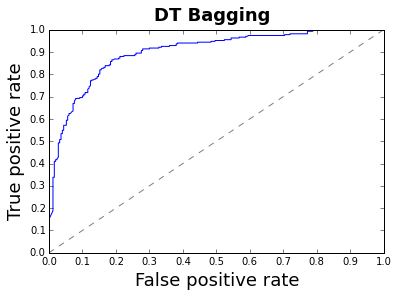

In [18]:
f.write("DT-Bagging\n")
dtc = ensemble.BaggingClassifier(n_estimators=25, max_features=0.2, n_jobs=-1)
startTime = time.time()
dtc.fit(featureTrain, labelTrain)
f.write("  RUNTIME-FIT  = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("RUNTIME-FIT  = %ss" % "{:.2f}".format(time.time() - startTime))
startTime = time.time()
supPreds = dtc.predict_proba(featureTest)
f.write("  RUNTIME-PRED = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("RUNTIME-PRED = %ss" % "{:.2f}".format(time.time() - startTime))
predLabelTest = [pred[1] for pred in supPreds]

fpr, tpr, thresholds = metrics.roc_curve(labelTest, predLabelTest)
plt.suptitle("DT Bagging", fontsize=18, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate", fontsize=18)
plt.ylabel("True positive rate", fontsize=18)
plt.axis([0, 1, 0, 1])
curve, = plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'grey', ls='--')
filepath = folder + '/' + graphname + '/ROC_DT-Bagging_TT-' + methodTT + "_FT-" + methodFT + "_labeled" + ".png"
pylab.savefig(filepath, dpi=300, bbox_inches='tight')
f.write("  AUC-ROC      = " + "{:.4f}".format(metrics.roc_auc_score(labelTest, predLabelTest)) + "\n")
print("AUC-ROC      =", "{:.4f}".format(metrics.roc_auc_score(labelTest, predLabelTest)))

AUC-PR       = 0.9057


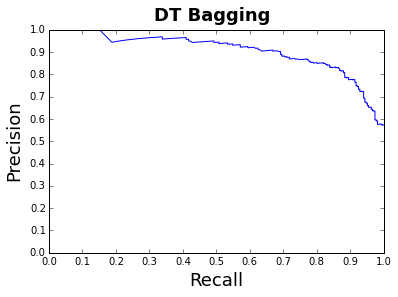

In [19]:
Y, X, thresholds = metrics.precision_recall_curve(labelTest, [x[1] for x in supPreds])
plt.suptitle("DT Bagging", fontsize=18, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall", fontsize=18)
plt.ylabel("Precision", fontsize=18)
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y)
filepath = folder + '/' + graphname + '/PR_DT-Bagging_TT-' + methodTT + "_FT-" + methodFT + "_labeled" + ".png"
pylab.savefig(filepath, dpi=300, bbox_inches='tight')

f.write("  AUC-PR       = " + "{:.4f}".format(pr.getAreaUnderCurve((X, Y))) + "\n\n")
print("AUC-PR       =", "{:.4f}".format(pr.getAreaUnderCurve((X, Y))))

RUNTIME-FIT  = 0.12s
RUNTIME-PRED = 0.01s
AUC-ROC      = 0.8931


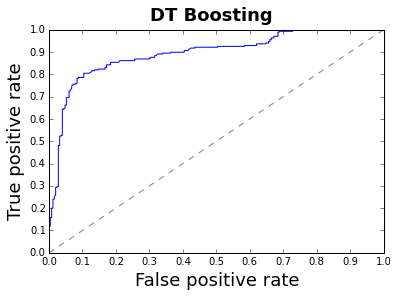

In [20]:
f.write("DT-Boosting\n")
dtc = ensemble.AdaBoostClassifier(n_estimators=50)
startTime = time.time()
dtc.fit(featureTrain, labelTrain)
f.write("  RUNTIME-FIT  = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("RUNTIME-FIT  = %ss" % "{:.2f}".format(time.time() - startTime))
startTime = time.time()
supPreds = dtc.predict_proba(featureTest)
f.write("  RUNTIME-PRED = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("RUNTIME-PRED = %ss" % "{:.2f}".format(time.time() - startTime))
predLabelTest = [pred[1] for pred in supPreds]
fpr, tpr, thresholds = metrics.roc_curve(labelTest, predLabelTest)
plt.suptitle("DT Boosting", fontsize=18, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate", fontsize=18)
plt.ylabel("True positive rate", fontsize=18)
plt.axis([0, 1, 0, 1])
curve, = plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'grey', ls='--')
filepath = folder + '/' + graphname + '/DT-Boosting_TT-' + methodTT + "_FT-" + methodFT + "_labeled" + ".png"
pylab.savefig(filepath, dpi=300, bbox_inches='tight')
f.write("  AUC-ROC      = " + "{:.4f}".format(metrics.roc_auc_score(labelTest, predLabelTest)) + "\n")
print("AUC-ROC      =", "{:.4f}".format(metrics.roc_auc_score(labelTest, predLabelTest)))

AUC-PR       = 0.9016


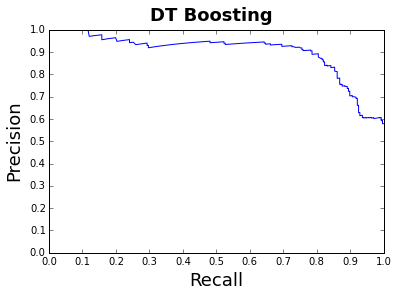

In [21]:
Y, X, thresholds = metrics.precision_recall_curve(labelTest, [x[1] for x in supPreds])
plt.suptitle("DT Boosting", fontsize=18, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall", fontsize=18)
plt.ylabel("Precision", fontsize=18)
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y)
filepath = folder + '/' + graphname + '/PR_DT-Boosting_TT-' + methodTT + "_FT-" + methodFT + "_labeled" + ".png"
pylab.savefig(filepath, dpi=300, bbox_inches='tight')

f.write("  AUC-PR       = " + "{:.4f}".format(pr.getAreaUnderCurve((X, Y))) + "\n\n")
print("AUC-PR       =", "{:.4f}".format(pr.getAreaUnderCurve((X, Y))))

RUNTIME-FIT  = 0.00s
RUNTIME-PRED = 0.00s
AUC-ROC      = 0.8159


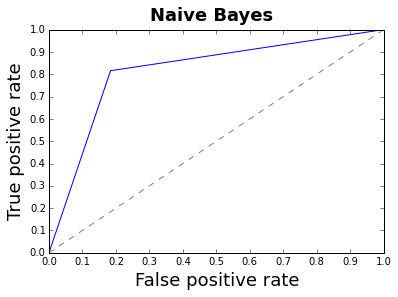

In [22]:
f.write("Naive Bayes\n")
dtc = naive_bayes.GaussianNB()
startTime = time.time()
dtc.fit(featureTrain, labelTrain)
f.write("  RUNTIME-FIT  = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("RUNTIME-FIT  = %ss" % "{:.2f}".format(time.time() - startTime))
startTime = time.time()
predLabelTest = dtc.predict(featureTest)
f.write("  RUNTIME-PRED = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("RUNTIME-PRED = %ss" % "{:.2f}".format(time.time() - startTime))
fpr, tpr, thresholds = metrics.roc_curve(labelTest, predLabelTest)
plt.suptitle("Naive Bayes", fontsize=18, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate", fontsize=18)
plt.ylabel("True positive rate", fontsize=18)
plt.axis([0, 1, 0, 1])
curve, = plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'grey', ls='--')
filepath = folder + '/' + graphname + '/Naive-Bayes_TT-' + methodTT + "_FT-" + methodFT + "_labeled" + ".png"
pylab.savefig(filepath, dpi=300, bbox_inches='tight')
f.write("  AUC-ROC      = " + "{:.4f}".format(metrics.roc_auc_score(labelTest, predLabelTest)) + "\n")
print("AUC-ROC      =", "{:.4f}".format(metrics.roc_auc_score(labelTest, predLabelTest)))

AUC-PR       = 0.9016


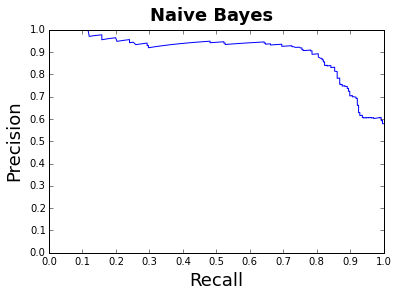

In [23]:
Y, X, thresholds = metrics.precision_recall_curve(labelTest, [x[1] for x in supPreds])
plt.suptitle("Naive Bayes", fontsize=18, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall", fontsize=18)
plt.ylabel("Precision", fontsize=18)
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y)
filepath = folder + '/' + graphname + '/PR_Naive-Bayes_TT-' + methodTT + "_FT-" + methodFT + "_labeled" + ".png"
pylab.savefig(filepath, dpi=300, bbox_inches='tight')

f.write("  AUC-PR       = " + "{:.4f}".format(pr.getAreaUnderCurve((X, Y))) + "\n\n")
print("AUC-PR       =", "{:.4f}".format(pr.getAreaUnderCurve((X, Y))))

RUNTIME = 0.00s
AUC-ROC = 0.9006


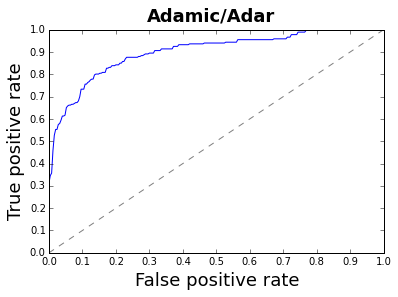

In [24]:
# Adamic/Adar
f.write("Adamic/Adar\n")
startTime = time.time()
predictions = adamicAdarIndex.runOnParallel(nodePairsTest)
f.write("  RUNTIME = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("RUNTIME = %ss" % "{:.2f}".format(time.time() - startTime))
saveROC("Adamic/Adar", predictions)
f.write("  AUC-ROC = " + "{:.4f}".format(roc.getAreaUnderCurve()) + "\n")
print("AUC-ROC =", "{:.4f}".format(roc.getAreaUnderCurve()))

AUC-PR  = 0.9152


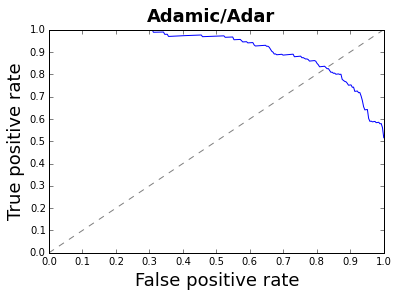

In [25]:
savePR("Adamic/Adar", predictions)
f.write("  AUC-PR  = " + "{:.4f}".format(pr.getAreaUnderCurve()) + "\n\n")
print("AUC-PR  =", "{:.4f}".format(pr.getAreaUnderCurve()))

RUNTIME = 0.01s
AUC-ROC = 0.7979


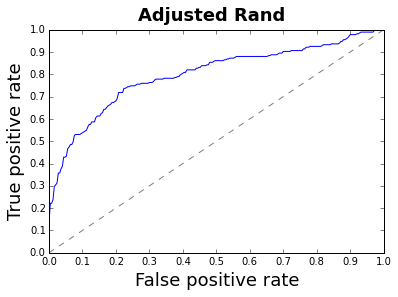

In [26]:
# Adjusted Rand
f.write("Adjusted Rand\n")
startTime = time.time()
predictions = adjustedRandIndex.runOnParallel(nodePairsTest)
f.write("  RUNTIME = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("RUNTIME = %ss" % "{:.2f}".format(time.time() - startTime))
saveROC("Adjusted Rand", predictions)
f.write("  AUC-ROC = " + "{:.4f}".format(roc.getAreaUnderCurve()) + "\n")
print("AUC-ROC =", "{:.4f}".format(roc.getAreaUnderCurve()))

AUC-PR  = 0.8315


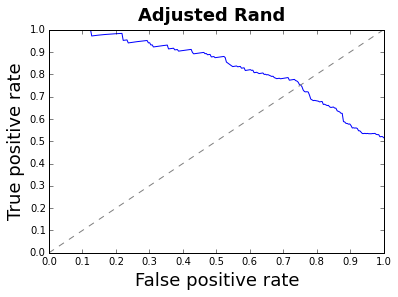

In [27]:
savePR("Adjusted Rand", predictions)
f.write("  AUC-PR  = " + "{:.4f}".format(pr.getAreaUnderCurve()) + "\n\n")
print("AUC-PR  =", "{:.4f}".format(pr.getAreaUnderCurve()))

RUNTIME = 0.00s
AUC-ROC = 0.8724


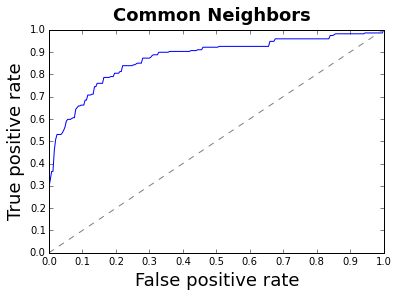

In [28]:
# Common Neighbors
f.write("Common Neighbors\n")
startTime = time.time()
predictions = commonNeighborsIndex.runOnParallel(nodePairsTest)
f.write("  RUNTIME = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("RUNTIME = %ss" % "{:.2f}".format(time.time() - startTime))
saveROC("Common Neighbors", predictions)
f.write("  AUC-ROC = " + "{:.4f}".format(roc.getAreaUnderCurve()) + "\n")
print("AUC-ROC =", "{:.4f}".format(roc.getAreaUnderCurve()))

AUC-PR  = 0.8956


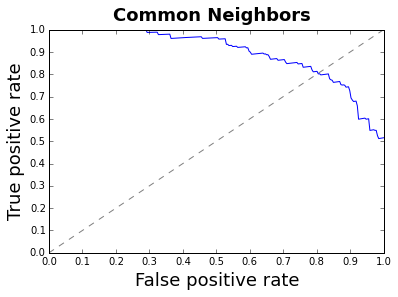

In [29]:
savePR("Common Neighbors", predictions)
f.write("  AUC-PR  = " + "{:.4f}".format(pr.getAreaUnderCurve()) + "\n\n")
print("AUC-PR  =", "{:.4f}".format(pr.getAreaUnderCurve()))

RUNTIME = 0.01s
AUC-ROC = 0.9138


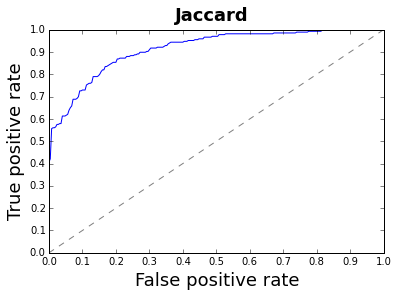

In [30]:
# Jaccard
f.write("Jaccard\n")
startTime = time.time()
predictions = jaccardIndex.runOnParallel(nodePairsTest)
f.write("  RUNTIME = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("RUNTIME = %ss" % "{:.2f}".format(time.time() - startTime))
saveROC("Jaccard", predictions)
f.write("  AUC-ROC = " + "{:.4f}".format(roc.getAreaUnderCurve()) + "\n")
print("AUC-ROC =", "{:.4f}".format(roc.getAreaUnderCurve()))

AUC-PR  = 0.9248


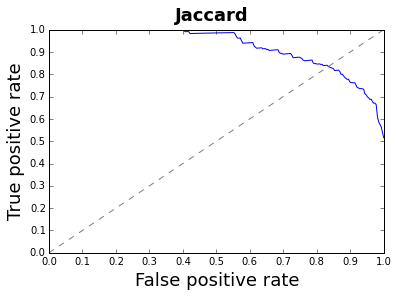

In [31]:
savePR("Jaccard", predictions)
f.write("  AUC-PR  = " + "{:.4f}".format(pr.getAreaUnderCurve()) + "\n\n")
print("AUC-PR  =", "{:.4f}".format(pr.getAreaUnderCurve()))

RUNTIME = 0.01s
AUC-ROC = 0.7651


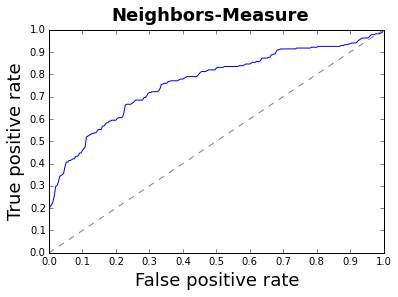

In [32]:
# Neighbors-Measure
f.write("Neighbors-Measure\n")
startTime = time.time()
predictions = neighborsMeasureIndex.runOnParallel(nodePairsTest)
f.write("  RUNTIME = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("RUNTIME = %ss" % "{:.2f}".format(time.time() - startTime))
saveROC("Neighbors-Measure", predictions)
f.write("  AUC-ROC = " + "{:.4f}".format(roc.getAreaUnderCurve()) + "\n")
print("AUC-ROC =", "{:.4f}".format(roc.getAreaUnderCurve()))

AUC-PR  = 0.8054


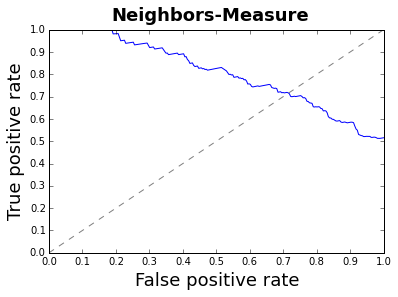

In [33]:
savePR("Neighbors-Measure", predictions)
f.write("  AUC-PR  = " + "{:.4f}".format(pr.getAreaUnderCurve()) + "\n\n")
print("AUC-PR  =", "{:.4f}".format(pr.getAreaUnderCurve()))

RUNTIME = 0.01s
AUC-ROC = 0.6168


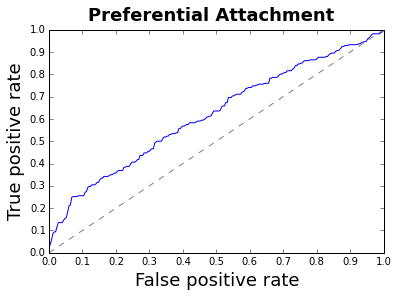

In [34]:
# Preferential Attachment
f.write("Preferential Attachment\n")
startTime = time.time()
predictions = preferentialAttachmentIndex.runOnParallel(nodePairsTest)
f.write("  RUNTIME = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("RUNTIME = %ss" % "{:.2f}".format(time.time() - startTime))
saveROC("Preferential Attachment", predictions)
f.write("  AUC-ROC = " + "{:.4f}".format(roc.getAreaUnderCurve()) + "\n")
print("AUC-ROC =", "{:.4f}".format(roc.getAreaUnderCurve()))

AUC-PR  = 0.6504


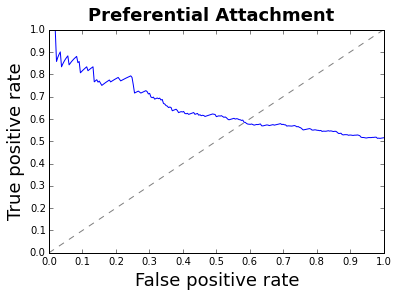

In [35]:
savePR("Preferential Attachment", predictions)
f.write("  AUC-PR  = " + "{:.4f}".format(pr.getAreaUnderCurve()) + "\n\n")
print("AUC-PR  =", "{:.4f}".format(pr.getAreaUnderCurve()))

RUNTIME = 0.00s
AUC-ROC = 0.9199


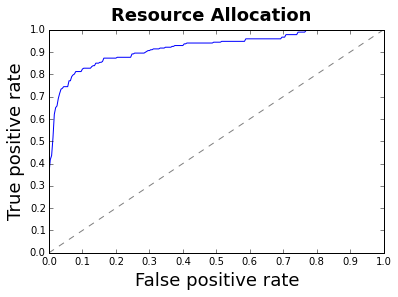

In [36]:
# Resource Allocation
f.write("Resource Allocation\n")
startTime = time.time()
predictions = resourceAllocationIndex.runOnParallel(nodePairsTest)
f.write("  RUNTIME = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("RUNTIME = %ss" % "{:.2f}".format(time.time() - startTime))
saveROC("Resource Allocation", predictions)
f.write("  AUC-ROC = " + "{:.4f}".format(roc.getAreaUnderCurve()) + "\n")
print("AUC-ROC =", "{:.4f}".format(roc.getAreaUnderCurve()))

AUC-PR  = 0.9356


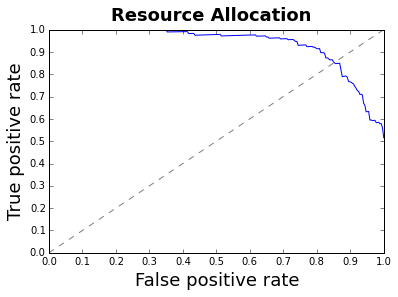

In [37]:
savePR("Resource Allocation", predictions)
f.write("  AUC-PR  = " + "{:.4f}".format(pr.getAreaUnderCurve()) + "\n\n")
print("AUC-PR  =", "{:.4f}".format(pr.getAreaUnderCurve()))

RUNTIME = 0.00s
AUC-ROC = 0.9157


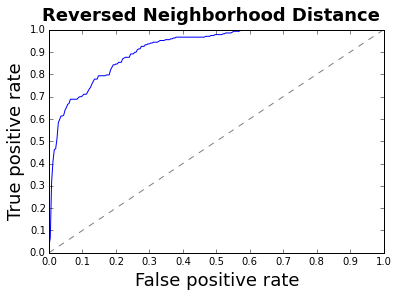

In [38]:
# Reversed Neighborhood Distance
f.write("Reversed Neighborhood Distance\n")
startTime = time.time()
predictions = reversedNeighborhoodDistanceIndex.runOnParallel(nodePairsTest)
f.write("  RUNTIME = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("RUNTIME = %ss" % "{:.2f}".format(time.time() - startTime))
saveROC("Reversed Neighborhood Distance", predictions)
f.write("  AUC-ROC = " + "{:.4f}".format(roc.getAreaUnderCurve()) + "\n")
print("AUC-ROC =", "{:.4f}".format(roc.getAreaUnderCurve()))

AUC-PR  = 0.9066


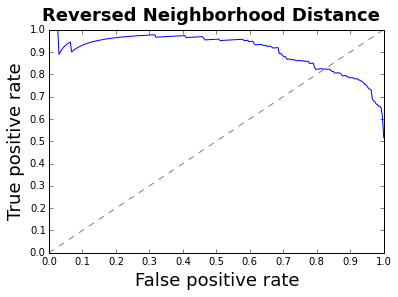

In [39]:
savePR("Reversed Neighborhood Distance", predictions)
f.write("  AUC-PR  = " + "{:.4f}".format(pr.getAreaUnderCurve()) + "\n\n")
print("AUC-PR  =", "{:.4f}".format(pr.getAreaUnderCurve()))

RUNTIME = 0.04s
AUC-ROC = 0.8725


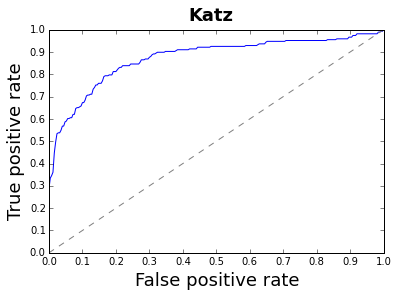

In [40]:
# Katz
f.write("Katz\n")
startTime = time.time()
predictions = katzIndex.runOnParallel(nodePairsTest)
f.write("  RUNTIME = " + "{:.2f}".format(time.time() - startTime) + "s\n")
print("RUNTIME = %ss" % "{:.2f}".format(time.time() - startTime))
saveROC("Katz", predictions)
f.write("  AUC-ROC = " + "{:.4f}".format(roc.getAreaUnderCurve()) + "\n")
print("AUC-ROC =", "{:.4f}".format(roc.getAreaUnderCurve()))

AUC-PR  = 0.8967


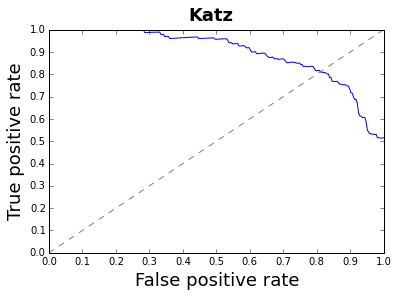

In [41]:
savePR("Katz", predictions)
f.write("  AUC-PR  = " + "{:.4f}".format(pr.getAreaUnderCurve()) + "\n\n")
print("AUC-PR  =", "{:.4f}".format(pr.getAreaUnderCurve()))

In [47]:
f.close()